In [4]:
import pandas as pd
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def load_asd_data_with_pandas(data_path: str = "/content/drive/MyDrive/Antibody_Chekalin_Denis/asd") -> pd.DataFrame:
    """
    Загружает все parquet файлы из папки asd в один pandas DataFrame

    Args:
        data_path: путь к папке с данными

    Returns:
        pd.DataFrame: объединенный DataFrame со всеми данными
    """
    # Получаем все parquet файлы из папки
    parquet_files = glob.glob(os.path.join(data_path, "part-*.parquet"))

    if not parquet_files:
        raise ValueError(f"Не найдено parquet файлов в папке {data_path}")

    print(f"Найдено {len(parquet_files)} parquet файлов")

    # Загружаем все файлы в список DataFrame'ов
    dataframes = []
    for file_path in parquet_files:
        # print(f"Загружаем файл: {os.path.basename(file_path)}")
        df = pd.read_parquet(file_path)
        dataframes.append(df)

    # Объединяем все DataFrame'ы в один
    combined_df = pd.concat(dataframes, ignore_index=True)

    print(f"Общий размер данных: {combined_df.shape}")
    print(f"Колонки: {list(combined_df.columns)}")

    return combined_df

# Загружаем данные
agab_df = load_asd_data_with_pandas('./asd')

Найдено 20 parquet файлов
Общий размер данных: (1227083, 11)
Колонки: ['dataset', 'heavy_sequence', 'light_sequence', 'scfv', 'affinity_type', 'affinity', 'antigen_sequence', 'confidence', 'nanobody', 'metadata', 'processed_measurement']


In [8]:
# Детальный анализ всех комбинаций affinity_type
print("=" * 60)
print("АНАЛИЗ AFFINITY_TYPE")
print("=" * 60)

print("\n1. Уникальные значения affinity_type:")
unique_types = agab_df['affinity_type'].unique()
print(f"Всего уникальных типов: {len(unique_types)}")
for i, aff_type in enumerate(unique_types, 1):
    print(f"  {i}. {aff_type}")

print("\n2. Количество записей по каждому типу:")
type_counts = agab_df['affinity_type'].value_counts()
print(type_counts)

print("\n3. Процентное распределение:")
type_percentages = agab_df['affinity_type'].value_counts(normalize=True) * 100
for aff_type, count in type_counts.items():
    percentage = type_percentages[aff_type]
    print(f"  {aff_type:25s}: {count:8,} записей ({percentage:5.2f}%)")

print("\n4. Комбинации affinity_type с dataset:")
print("\nРаспределение по dataset для каждого affinity_type:")
for aff_type in sorted(unique_types):
    subset = agab_df[agab_df['affinity_type'] == aff_type]
    dataset_dist = subset['dataset'].value_counts()
    print(f"\n  {aff_type}:")
    for dataset, count in dataset_dist.items():
        pct = (count / len(subset)) * 100
        print(f"    {dataset:15s}: {count:6,} ({pct:5.2f}%)")

print("\n5. Общая статистика:")
print(f"  Всего записей: {len(agab_df):,}")
print(f"  Записей с affinity_type: {agab_df['affinity_type'].notna().sum():,}")
print(f"  Пропущенных значений: {agab_df['affinity_type'].isna().sum():,}")

АНАЛИЗ AFFINITY_TYPE

1. Уникальные значения affinity_type:
Всего уникальных типов: 10
  1. elisa_mut_to_wt_ratio
  2. ddg
  3. bool
  4. ic_50
  5. kd
  6. fuzzy
  7. alphaseq
  8. log_enrichment
  9. -log KD
  10. delta_g

2. Количество записей по каждому типу:
affinity_type
fuzzy                    524346
bool                     336761
alphaseq                 198703
-log KD                  152401
kd                         7007
log_enrichment             3452
delta_g                    2725
ddg                         670
elisa_mut_to_wt_ratio       658
ic_50                       360
Name: count, dtype: int64

3. Процентное распределение:
  fuzzy                    :  524,346 записей (42.73%)
  bool                     :  336,761 записей (27.44%)
  alphaseq                 :  198,703 записей (16.19%)
  -log KD                  :  152,401 записей (12.42%)
  kd                       :    7,007 записей ( 0.57%)
  log_enrichment           :    3,452 записей ( 0.28%)
  delta_g       

In [6]:
agab_df['affinity_type'].unique()

array(['elisa_mut_to_wt_ratio', 'ddg', 'bool', 'ic_50', 'kd', 'fuzzy',
       'alphaseq', 'log_enrichment', '-log KD', 'delta_g'], dtype=object)

In [7]:
agab_df[['affinity_type', 'dataset']].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

### Распределение типов антител

In [11]:
# Создаем категории записей
def categorize_antibody(row):
    """Категоризирует запись по типу антитела"""
    has_heavy = pd.notna(row['heavy_sequence']) and row['heavy_sequence'] != ''
    has_light = pd.notna(row['light_sequence']) and row['light_sequence'] != ''
    
    if row['scfv'] == True:
        return 'scFv'
    elif row['nanobody'] == True:
        return 'Nanobody'
    elif has_heavy and has_light:
        return 'Paired (heavy + light)'
    elif has_heavy and not has_light:
        return 'Heavy-only'
    elif not has_heavy and has_light:
        return 'Light-only'
    else:
        return 'No sequences'

# Применяем категоризацию
agab_df['antibody_type'] = agab_df.apply(categorize_antibody, axis=1)

# Распределение по типам
print("Распределение записей по типам антител:")
print(agab_df['antibody_type'].value_counts())
print("\nПроцентное распределение:")
print(agab_df['antibody_type'].value_counts(normalize=True) * 100)

# Фокус на записях с scFv == False и nanobody == False
print("\n" + "="*60)
print("Детальный анализ записей с scFv == False и nanobody == False:")
print("="*60)

filtered_df = agab_df[
    (agab_df['scfv'] == False) 
    & (agab_df['nanobody'] == False)
]

print(f"\nВсего таких записей: {len(filtered_df)}")

# Распределение по типам среди отфильтрованных
print("\nРаспределение по типам среди отфильтрованных записей:")
filtered_types = filtered_df.apply(categorize_antibody, axis=1)
print(filtered_types.value_counts())
print("\nПроцентное распределение:")
print(filtered_types.value_counts(normalize=True) * 100)


Распределение записей по типам антител:
antibody_type
Paired (heavy + light)    716176
Heavy-only                188742
scFv                      132157
Nanobody                  110904
Light-only                 79104
Name: count, dtype: int64

Процентное распределение:
antibody_type
Paired (heavy + light)    58.364104
Heavy-only                15.381356
scFv                      10.770013
Nanobody                   9.038019
Light-only                 6.446508
Name: proportion, dtype: float64

Детальный анализ записей с scFv == False и nanobody == False:

Всего таких записей: 980878

Распределение по типам среди отфильтрованных записей:
Paired (heavy + light)    713227
Heavy-only                188626
Light-only                 79025
Name: count, dtype: int64

Процентное распределение:
Paired (heavy + light)    72.713120
Heavy-only                19.230322
Light-only                 8.056557
Name: proportion, dtype: float64


In [13]:
print(f"Всего записей с scFv == False и nanobody == False: {len(filtered_df)}")

# Смотрим на распределение по dataset
print("\nРаспределение по dataset для записей с пустыми light_sequence:")
print(empty_light['dataset'].value_counts().head(10))

print("\nРаспределение по dataset для записей с пустыми heavy_sequence:")
print(empty_heavy['dataset'].value_counts().head(10))


Всего записей с scFv == False и nanobody == False: 980878

Распределение по dataset для записей с пустыми light_sequence:
dataset
patents       76588
covid-19      54625
hiv           48008
met            4000
biomap         2725
genbank        2603
literature       42
aae              35
Name: count, dtype: int64

Распределение по dataset для записей с пустыми heavy_sequence:
dataset
patents    78737
genbank      288
Name: count, dtype: int64


### Смотрим на примере dataset = patents

In [16]:
# Считаем количество записей с пустыми light_sequence и heavy_sequence для dataset = patents

# Фильтрация по dataset = patents и scFv == False и nanobody == False
patents_df = agab_df[
    (agab_df['dataset'] == 'patents')
    & (agab_df['scfv'] == False)
    & (agab_df['nanobody'] == False)
]

# Условия для пустых light_sequence и heavy_sequence
empty_light_patents = patents_df['light_sequence'].isnull() | (patents_df['light_sequence'] == '')
empty_heavy_patents = patents_df['heavy_sequence'].isnull() | (patents_df['heavy_sequence'] == '')

# Подсчёт количества каждого случая
both_empty = patents_df[empty_light_patents & empty_heavy_patents].shape[0]
only_light_empty = patents_df[empty_light_patents & ~empty_heavy_patents].shape[0]
only_heavy_empty = patents_df[~empty_light_patents & empty_heavy_patents].shape[0]
none_empty = patents_df[~empty_light_patents & ~empty_heavy_patents].shape[0]

print("Для dataset = patents:")
print(f"  Пустые оба (light_sequence и heavy_sequence): {both_empty}")
print(f"  Пустой только light_sequence: {only_light_empty}")
print(f"  Пустой только heavy_sequence: {only_heavy_empty}")
print(f"  Оба заполнены: {none_empty}")


Для dataset = patents:
  Пустые оба (light_sequence и heavy_sequence): 0
  Пустой только light_sequence: 76588
  Пустой только heavy_sequence: 78737
  Оба заполнены: 21621


### Смотрим на примере dataset = covid-19

In [17]:
# Считаем количество записей с пустыми light_sequence и heavy_sequence для dataset = covid-19

# Фильтрация по dataset = covid-19 и scFv == False и nanobody == False
covid_df = agab_df[
    (agab_df['dataset'] == 'covid-19')
    & (agab_df['scfv'] == False)
    & (agab_df['nanobody'] == False)
]

# Условия для пустых light_sequence и heavy_sequence
empty_light_covid = covid_df['light_sequence'].isnull() | (covid_df['light_sequence'] == '')
empty_heavy_covid = covid_df['heavy_sequence'].isnull() | (covid_df['heavy_sequence'] == '')

# Подсчёт количества каждого случая
both_empty = covid_df[empty_light_covid & empty_heavy_covid].shape[0]
only_light_empty = covid_df[empty_light_covid & ~empty_heavy_covid].shape[0]
only_heavy_empty = covid_df[~empty_light_covid & empty_heavy_covid].shape[0]
none_empty = covid_df[~empty_light_covid & ~empty_heavy_covid].shape[0]

print("Для dataset = covid-19:")
print(f"  Пустые оба (light_sequence и heavy_sequence): {both_empty}")
print(f"  Пустой только light_sequence: {only_light_empty}")
print(f"  Пустой только heavy_sequence: {only_heavy_empty}")
print(f"  Оба заполнены: {none_empty}")


Для dataset = covid-19:
  Пустые оба (light_sequence и heavy_sequence): 0
  Пустой только light_sequence: 54625
  Пустой только heavy_sequence: 0
  Оба заполнены: 0


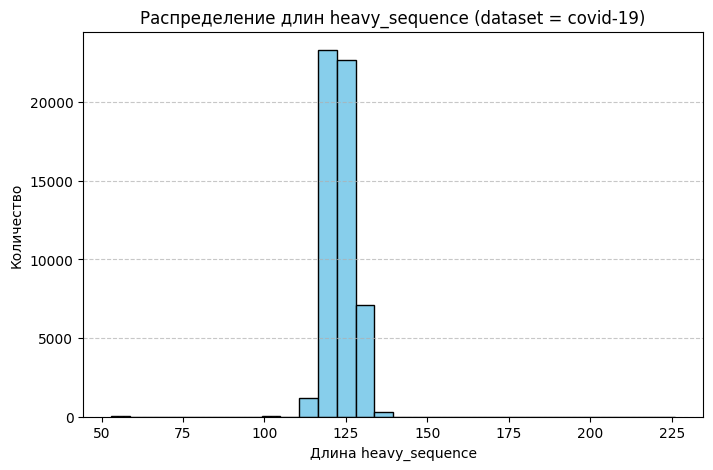

In [30]:
# Вычисляем длины heavy_sequence, исключая пустые и nan
heavy_lengths = covid_df['heavy_sequence'].dropna().apply(len)

plt.figure(figsize=(8, 5))
plt.hist(heavy_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение длин heavy_sequence (dataset = covid-19)')
plt.xlabel('Длина heavy_sequence')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import pandas as pd

# Загружаем датасет CoV-AbDab_080224.csv
cov_abdab_df = pd.read_csv('CoV-AbDab_080224.csv')

# Сравниваем по количеству строк и колонок
print("Форма covid_df:", covid_df.shape)
print("Форма CoV-AbDab_080224.csv:", cov_abdab_df.shape)


Форма covid_df: (54625, 12)
Форма CoV-AbDab_080224.csv: (12918, 23)
Невозможно сравнить по уникальному ключу ('name' не найден).


In [33]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
cov_abdab_df.head()

,Name,Ab or Nb,Binds to,Doesn't Bind to,Neutralising Vs,Not Neutralising Vs,Protein + Epitope,Origin,VHorVHH,VL,Heavy V Gene,Heavy J Gene,Light V Gene,Light J Gene,CDRH3,CDRL3,Structures,ABB Homology Model (if no structure),Sources,Date Added,Last Updated,Update Description,Notes/Following Up?
0,Curtis_3548_S-2,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,SARS-CoV2_WT (weak),NaN,S; RBD/non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,IGHV4-31 (Human),IGHJ4 (Human),ND,ND,ARGSRNDLRDFDY,QSYNSSLSGLVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
1,Curtis_3548_S-7,Ab,SARS-CoV2_WT;SARS-CoV2_Beta,SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; non-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,IGHV4-34 (Human),IGHJ4 (Human),ND,ND,AREPYSSGMGGRDY,QQYGSSPYT,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
2,Curtis_3548_RBD-15,Ab,SARS-CoV2_WT,SARS-CoV2_Beta;SARS-CoV2_Omicron-BA1;HKU1,NaN,SARS-CoV2_WT,S; iso-RBD,B-cells; SARS-CoV2 Human Patient,ND,ND,IGHV4-59 (Human),IGHJ5 (Human),ND,ND,AKGIYSSSSYWFGP,QAWDSSTVV,ND,NaN,"Nicholas Curtis et al., 2023 (https://www.bior...","Feb 8, 2024","Feb 8, 2024",NaN,Binds only non-prefusion stabilised RBD. Complete
3,8-D9,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,S; RBD,B-cells; SARS-CoV2 Human Vaccinee (BBIBP-CorV),VQLVESGGGLVQPGGSLRLSCAASGLTVSSNYMNWVRQAPGKGLEW...,DIQMTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKL...,IGHV3-66 (Human),IGHJ3 (Human),IGKV1-9 (Human),IGKJ3 (Human),ARDHSGHALDI,QHLNSYPSMYT,https://www.rcsb.org/structure/8J1T;https://ww...,NaN,"Wanbo Tai et al., 2023 (https://www.nature.com...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
4,Sun_1G11,Ab,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,NaN,SARS-CoV2_WT;SARS-CoV2_Alpha;SARS-CoV2_Beta;SA...,SARS-CoV2_Omicron-BQ1;SARS-CoV2_Omicron-BQ1.1;...,S; RBD,B-cells; SARS-CoV2 Human Patient,EVQLVESGGGLVQPGRSLRLSCAASGFKFDDYAMHWVRQAPGKGLE...,DIQLTQSPSFLSASVGDRVTITCRASQGIDKYLAWYQQKPGQAPKV...,IGHV3-9 (Human),IGHJ4 (Human),IGKV1-9 (Human),IGKJ3 (Human),VKDSNYDSSGYLINNFDY,QQLYTFPVT,https://www.rcsb.org/structure/8IX3,NaN,"Hui Sun et al., 2023 (https://journals.asm.org...","Feb 8, 2024","Feb 8, 2024",NaN,Complete
